In [1]:
import numpy as np
import GEOparse as gp
import pandas as pd
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt
from IPython.display import display
import sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn
import combat
import math
from combat.pycombat import pycombat

We download the data from the GSE dataset

In [2]:
gse1 = gp.get_GEO(geo="GSE157239", destdir="./")
gse2 = gp.get_GEO(geo="GSE147232", destdir="./")

06-Dec-2020 15:58:04 DEBUG utils - Directory ./ already exists. Skipping.
06-Dec-2020 15:58:04 INFO GEOparse - Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE157nnn/GSE157239/soft/GSE157239_family.soft.gz to ./GSE157239_family.soft.gz
100%|██████████| 18.2M/18.2M [00:09<00:00, 2.09MB/s]  
06-Dec-2020 15:58:16 DEBUG downloader - Size validation passed
06-Dec-2020 15:58:16 DEBUG downloader - Moving /var/folders/wm/00f0x3k57990311z8kmv1xlm0000gn/T/tmpec5018je to /Users/dylankim/Desktop/SENIOR/QCB 455/alzheimer_analysis/GSE157239_family.soft.gz
06-Dec-2020 15:58:16 DEBUG downloader - Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE157nnn/GSE157239/soft/GSE157239_family.soft.gz
06-Dec-2020 15:58:16 INFO GEOparse - Parsing ./GSE157239_family.soft.gz: 
06-Dec-2020 15:58:16 DEBUG GEOparse - DATABASE: GeoMiame
06-Dec-2020 15:58:16 DEBUG GEOparse - SERIES: GSE157239
06-Dec-2020 15:58:16 DEBUG GEOparse - PLATFORM: GPL21572
/Library/Frameworks/Python.framework/Versions/3.8/l

In [34]:
# Significance level
alpha2 = 0.01

# Identifying which samples are controls
control_columns2 = np.array([0, 1, 2, 3, 4])
c2 = np.zeros(10, dtype=bool)
c2[control_columns2] = 1

#print(gse2.gsms)
values2 = []
for _, v in gse2.gsms.items():
    ids2 = v.table["ID_REF"].to_numpy()
    values2.append(v.table['VALUE'].to_numpy())
values2 = np.stack(values2, axis=-1)

# Getting rid of the NaNs in the values array
nan_array = []
print(len(values2[:, 0]))
for i in np.arange(len(values2[:, 0])):
    for j in np.arange(len(values2[0, :])):
        if np.isnan(values2[i, j]):
            nan_array.append(i)

values2 = np.delete(values2, nan_array, axis = 0) 
ids2 = np.delete(ids2, nan_array, axis = 0)

#print(gse2.gpls['GPL18058'].table)
raw_data2 = gse2.gpls['GPL18058'].table
#print(raw_data2)
raw_data2 = raw_data2[pd.notna(raw_data2['Human_miRNA'])]
raw_ids2 = raw_data2['ID'].to_numpy()

mirna_idxs2 = [i for i, x in enumerate(ids2) if np.any(raw_ids2 == x)]
mirna_ids2 = ids2[mirna_idxs2]
values2 = values2[mirna_idxs2]

mask2 = np.broadcast_to(c2, (len(values2), 10))

controls2 = values2[mask2].reshape(-1, 5)
samples2 = values2[~mask2].reshape(-1, 5)

# Running one-way ANOVA analysis on the RNAs
f_stats2 = stats.f_oneway(controls2, samples2, axis=-1)
num_significant2 = np.sum(f_stats2.pvalue < alpha2)
signif_ids2 = mirna_ids2[f_stats2.pvalue < alpha2]

# Sorting by p-value
ids2 = np.array(ids2)
order2 = np.argsort(f_stats2.pvalue)
sorted_ids2 = ids2[order2]

sorted_pvalues2 = np.copy(f_stats2.pvalue)
sorted_pvalues2.sort()

print("number of samples: ", len(f_stats2.pvalue))

3556
[ 13138  42638  42888 ... 168816 169280 168835]
number of samples:  2135


Text(0, 0.5, 'Frequency')

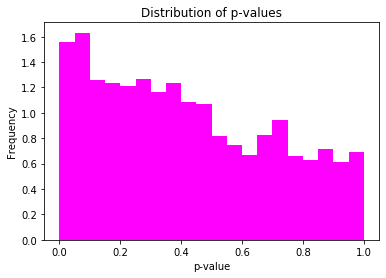

In [4]:
signifs2 = []
mirna_signif_ids2 = []
for sig_id2 in signif_ids2:
    if not any(raw_data2["ID"] == sig_id2):
        continue
    signifs2.append(raw_data2[raw_data2["ID"] == sig_id2])
    mirna_signif_ids2.append(sig_id2)

signifs2 = pd.concat(signifs2)
mirna_signif_id_mask2 = [np.nonzero(mirna_ids2 == i)[0][0] for i in mirna_signif_ids2] #watch

signifs2.insert(0, "P-value", f_stats2.pvalue[mirna_signif_id_mask2])

signif_indices2 = []
for i in np.arange(len(f_stats2.pvalue)):
    if f_stats2.pvalue[i] < alpha2:
        signif_indices2.append(i)

# Plotting distribution of p-values
plt.hist(sorted_pvalues2, bins = 20, color = 'magenta', density = True)
plt.title('Distribution of p-values')
plt.xlabel('p-value')
plt.ylabel('Frequency')

#mirna_mask2 = signifs2['Sequence Type'] == 'miRNA'
#mirna_signifs2 = signifs2[mirna_mask]

In [5]:
regulations2 = np.mean(samples2, axis=-1) > np.mean(controls2, axis=-1)

# True if upregulated, False if downregulated
signif_regulations2 = regulations2[mirna_signif_id_mask2]

labeled_sig_regs2 = np.stack([
    signifs2['Human_miRNA'].to_numpy(),
    signif_regulations2
], axis=-1)

print(labeled_sig_regs2)


[['hsa-miR-561-3p' False]
 ['hsa-miR-5194' True]
 ['hsa-miR-554' False]
 ['hsa-miR-4326' False]
 ['hsa-miR-4790-3p' False]
 ['hsa-miR-4745-3p' False]
 ['hsa-miR-518d-3p' False]
 ['hsa-miR-3921' False]
 ['hsa-miR-5583-5p' False]
 ['hsa-miR-5686' False]
 ['spike_control_v2_5' False]
 ['hsa-miR-3620' False]
 ['hsa-miR-3177-5p' False]
 ['hsa-miR-200c-5p' False]
 ['hsa-miR-548c-3p' False]
 ['hsa-miR-3687' False]
 ['hsa-miR-5188' False]
 ['hsa-miR-548x-3p' False]
 ['hsa-miR-5708' False]
 ['hsv1-miR-H17' False]
 ['hsa-miR-4747-5p' True]
 ['spike_control_v1_d' False]
 ['hsa-miR-196a-3p' False]
 ['spike_control_v2_1' False]
 ['hsa-let-7e-3p' False]
 ['hsa-miR-3678-3p' False]
 ['hsa-miR-5196-5p' False]
 ['hsa-miR-4638-5p' False]
 ['hsa-miR-4474-5p' False]
 ['hsv2-miR-H11' False]
 ['hsa-miR-938' False]
 ['hsa-miR-1909-3p' False]
 ['hsa-miR-4297' True]
 ['hsa-miR-1273g-5p' False]
 ['hsa-miR-4722-5p' True]
 ['spike_control_v2_23' False]
 ['hsa-miR-3200-3p' True]
 ['hsa-miR-4668-3p' False]]


In [6]:
# Normalizing data for clustering
values_norm2 = values2

values_norm2 = values_norm2 - np.mean(values_norm2, axis=-1, keepdims=True)
values_norm2 = values_norm2 / np.std(values_norm2, axis=-1, keepdims=True)

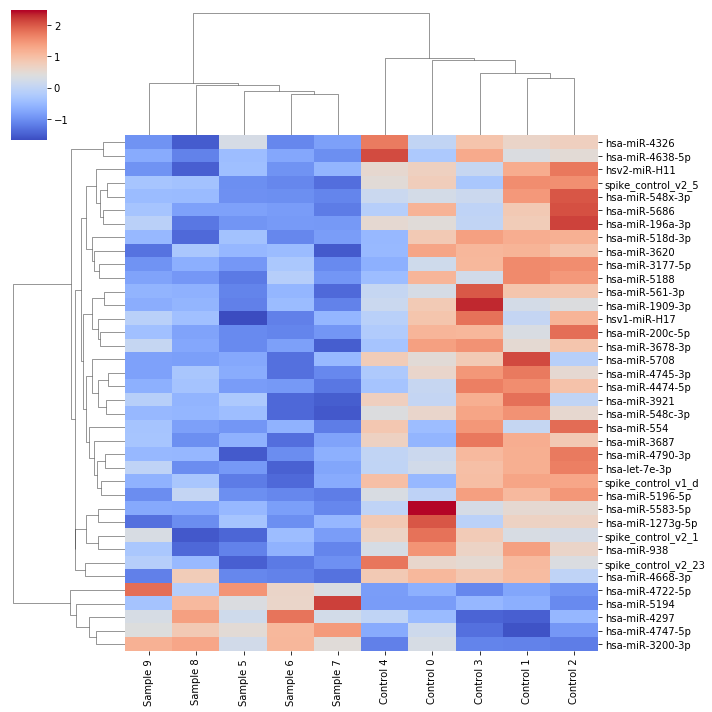

In [7]:
# Clustermap
dendro_df2 = pd.DataFrame(values_norm2[mirna_signif_id_mask2])
dendro_df2.columns = [('Control ' if i in control_columns2 else 'Sample ') + str(i) for i in range(10)]
dendro_df2.index = list(signifs2['Human_miRNA'])
display(seaborn.clustermap(dendro_df2, cmap='coolwarm'))

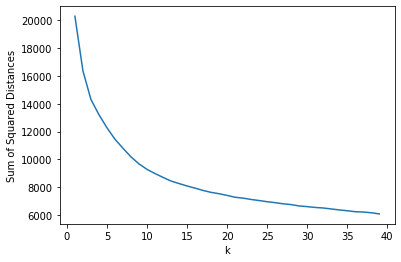

In [8]:
# K-means clustering
sum_of_squared_distances2 = []
for k in range(1, 40):
    kmeans2 = KMeans(n_clusters = k, n_init = 20).fit(values_norm2)
    sum_of_squared_distances2.append(kmeans2.inertia_)
    
plt.plot(range(1, 40), sum_of_squared_distances2)
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.show()

In [9]:
kmeans2 = KMeans(n_clusters = 8).fit(values_norm2)

#argmin, distance = sklearn.metrics.pairwise_distances_argmin_min(kmeans.cluster_centers_, values_norm)
#print(ids[argmin])

signif_labels_list2 = kmeans2.labels_[signif_indices2]
mirna_signif_labels_list2 = signif_labels_list2[0:38]

print(mirna_signif_labels_list2)

[7 5 2 7 2 7 7 7 6 2 2 7 7 2 7 7 2 2 0 7 5 7 2 6 2 7 7 4 7 2 6 7 5 6 3 7 5
 7]


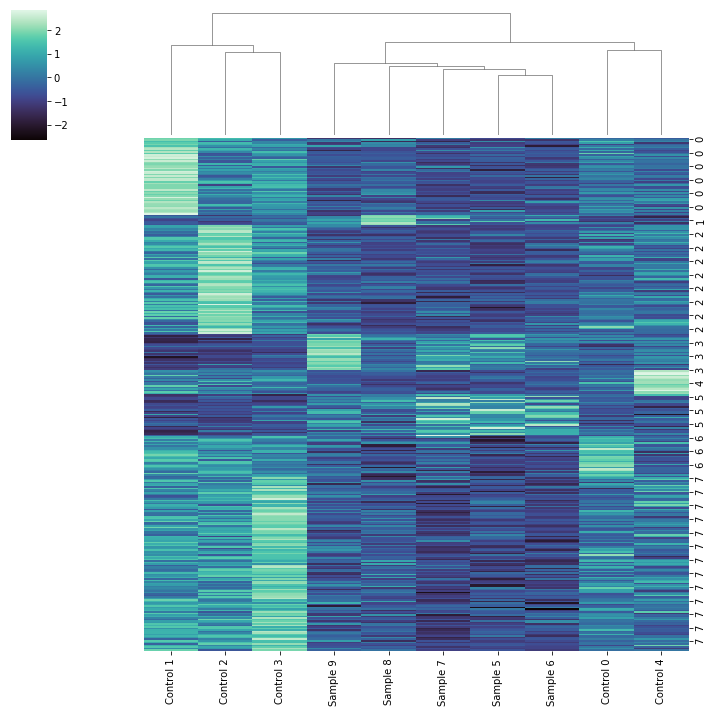

In [10]:
signif_level2 = 0.1
order2 = np.argsort(kmeans2.labels_[f_stats2.pvalue < signif_level2])
clustered_values2 = values_norm2[f_stats2.pvalue < signif_level2][order2]
value_df2 = pd.DataFrame(clustered_values2)
value_df2.index = kmeans2.labels_[f_stats2.pvalue < signif_level2][order2]
value_df2.columns = [('Control ' if i in control_columns2 else 'Sample ') + str(i) for i in range(10)]
seaborn.clustermap(value_df2, cmap='mako', row_cluster=False, col_cluster=True)

In [11]:
# Significance level
alpha = 0.01

# Identifying which samples are controls
control_columns = np.array([0, 1, 2, 4, 6, 9, 11, 15])
c = np.zeros(16, dtype=bool)
c[control_columns] = 1

# Creating accessible matrices from the dataset
values = []
for k, v in gse1.gsms.items():
    ids = v.table["ID_REF"].to_numpy()
    values.append(v.table['VALUE'].to_numpy())
values = np.stack(values, axis=-1)

raw_data = gse1.gpls['GPL21572'].table
raw_data = raw_data[raw_data['Sequence Type'] == 'miRNA']
raw_ids = raw_data['ID'].to_numpy()
mirna_idxs = [i for i, x in enumerate(ids) if np.any(raw_ids == x)]
mirna_ids = ids[mirna_idxs]
values = values[mirna_idxs]
print("Number of miRNA samples", values.shape[0])

mask = np.broadcast_to(c, (len(values), 16))

controls = values[mask].reshape(-1, 8)
samples = values[~mask].reshape(-1, 8)

# Running one-way ANOVA analysis on the RNAs
f_stats = stats.f_oneway(controls, samples, axis=-1)
num_significant = np.sum(f_stats.pvalue < alpha)
signif_ids = mirna_ids[f_stats.pvalue < alpha]

# Sorting by p-value
ids = np.array(ids)
order = np.argsort(f_stats.pvalue)
sorted_ids = ids[order]

Number of miRNA samples 2578


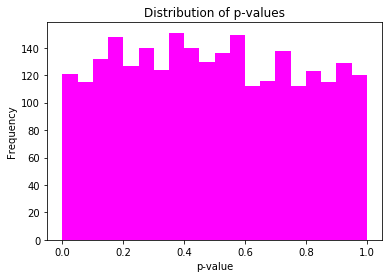

In [12]:
signifs = []
mirna_signif_ids = []
for sig_id in signif_ids:
    if not any(raw_data["ID"] == sig_id):
        continue
    signifs.append(raw_data[raw_data["ID"] == sig_id])
    mirna_signif_ids.append(sig_id)

signifs = pd.concat(signifs)
mirna_signif_id_mask = [np.nonzero(ids == i)[0][0] for i in mirna_signif_ids]
signifs.insert(17, "P-value", f_stats.pvalue[mirna_signif_id_mask])

sorted_pvalues = np.copy(f_stats.pvalue)
sorted_pvalues.sort()

signif_indices = []
for i in np.arange(len(f_stats.pvalue)):
    if f_stats.pvalue[i] < alpha:
        signif_indices.append(i)

# Plotting distribution of p-values
plt.hist(sorted_pvalues, bins = 20, color = 'magenta')
plt.title('Distribution of p-values')
plt.xlabel('p-value')
plt.ylabel('Frequency')

mirna_mask = signifs['Sequence Type'] == 'miRNA'
mirna_signifs = signifs[mirna_mask]

To determine if each gene is upregulated or downregulated, we compare the mean values against the control.

In [13]:
regulations = np.mean(samples, axis=-1) > np.mean(controls, axis=-1)

# True if upregulated, False if downregulated
signif_regulations = regulations[mirna_signif_id_mask]

labeled_sig_regs = np.stack([
    signifs['Transcript ID(Array Design)'].to_numpy(),
    signif_regulations
], axis=-1)

print(labeled_sig_regs)

[['hsa-miR-215-3p' True]
 ['hsa-miR-369-5p' False]
 ['hsa-miR-429' True]
 ['hsa-miR-767-5p' False]
 ['hsa-miR-1251-5p' False]
 ['hsa-miR-1470' True]
 ['hsa-miR-3180-5p' False]
 ['hsa-miR-4286' False]
 ['hsa-miR-500b-3p' False]
 ['hsa-miR-3912-5p' True]
 ['hsa-miR-3929' True]
 ['hsa-miR-4540' True]
 ['hsa-miR-4633-3p' True]
 ['hsa-miR-4653-5p' True]
 ['hsa-miR-203b-5p' True]
 ['hsa-miR-4791' False]
 ['hsa-miR-5003-3p' False]
 ['hsa-miR-5093' False]
 ['hsa-miR-6877-5p' False]
 ['hsa-miR-7155-3p' False]]


In [14]:
# Creating table of p-values, regulation patterns, and functions of each miRNA of interest
data = {'P-value': signifs['P-value'].values, 
        'Regulation (case vs. control)':['Upregulated', 'Downregulated', 'Upregulated', 'Downregulated', 'Downregulated', 'Upregulated', 'Downregulated', 'Downregulated', 'Downregulated', 'Upregulated', 
                                         'Upregulated', 'Upregulated', 'Upregulated', 'Upregulated', 'Upregulated', 'Downregulated', 'Downregulated', 'Downregulated', 'Downregulated', 'Downregulated'], 
        'Function':['Tumor suppression', 'Cell proliferation', 'Tumor suppression', 'DNA methylation', 'Regulates A\u03B2', 'Cell proliferation', 'Cell proliferation', 'Cell proliferation',
                   'Tumor suppression', 'Tumor suppression', 'Lipid metabolism', 'N/A', 'N/A', 'N/A', 'Tumor suppression', 'N/A', 'N/A', 'N/A', 'N/A', 'Regulate autoimmune disease']} 


df = pd.DataFrame(data, index =['miR-215-3p', 'miR-369-5p', 'miR-429', 'miR-767-5p', 'miR-1251-5p', 'miR-1470', 'miR-3180-5p', 'miR-4286', 'miR-500b-3p', 'miR-3912-5p', 'miR-3929', 'miR-4540', 'miR-4633-3p',
                               'miR-4653-5p', 'miR-203b-5p', 'miR-4791', 'miR-5003-3p', 'miR-5093', 'miR-6877-5p', 'miR-7155-3p']) 

display(df)


,P-value,Regulation (case vs. control),Function
miR-215-3p,0.008630,Upregulated,Tumor suppression
miR-369-5p,0.003104,Downregulated,Cell proliferation
miR-429,0.007773,Upregulated,Tumor suppression
miR-767-5p,0.006993,Downregulated,DNA methylation
miR-1251-5p,0.009721,Downregulated,Regulates Aβ
miR-1470,0.009135,Upregulated,Cell proliferation
miR-3180-5p,0.002045,Downregulated,Cell proliferation
miR-4286,0.000047,Downregulated,Cell proliferation
miR-500b-3p,0.001586,Downregulated,Tumor suppression
miR-3912-5p,0.002591,Upregulated,Tumor suppression


In [15]:
# Normalizing data for clustering
values_norm = values

values_norm = values_norm - np.mean(values_norm, axis=-1, keepdims=True)
values_norm = values_norm / np.std(values_norm, axis=-1, keepdims=True)

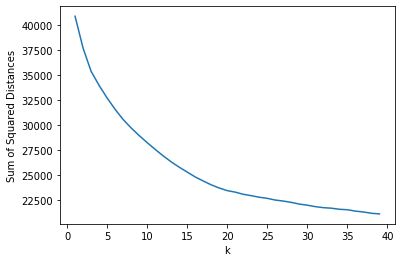

In [16]:
# K-means clustering
sum_of_squared_distances = []
for k in range(1, 40):
    kmeans = KMeans(n_clusters = k, n_init = 20).fit(values_norm)
    sum_of_squared_distances.append(kmeans.inertia_)
    
plt.plot(range(1, 40), sum_of_squared_distances)
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.show()


In [17]:
kmeans = KMeans(n_clusters = 8, n_init = 20).fit(values_norm)

#argmin, distance = sklearn.metrics.pairwise_distances_argmin_min(kmeans.cluster_centers_, values_norm)
#print(ids[argmin])

signif_labels_list = kmeans.labels_[signif_indices]
mirna_signif_labels_list = signif_labels_list[0:20]

print(mirna_signif_labels_list)

[4 1 6 7 3 6 1 3 1 0 6 6 6 6 6 5 5 5 1 5]


In [18]:
# Here we analyze the functions within each cluster above
unknown_idxs = [mirna_signif_id_mask[i] for i in range(len(mirna_signif_id_mask)) if list(df['Function'])[i] == 'N/A']
unknown_clusters = [mirna_signif_labels_list[i] for i in range(len(mirna_signif_id_mask)) if list(df['Function'])[i] == 'N/A']

num_nearest = 3

for unknown_idx, cluster in zip(unknown_idxs, unknown_clusters):
    print(f"Nearest items in cluster {cluster} with {raw_data['Transcript ID(Array Design)'][raw_data['ID'] == mirna_ids[unknown_idx]].item()}")
    in_cluster = (kmeans.labels_ == cluster)
    cluster_center = kmeans.cluster_centers_[cluster]
    
    distances_to_center = values_norm[in_cluster] @ cluster_center
    closest = np.argsort(distances_to_center)[-num_nearest:]
    near_ids = mirna_ids[in_cluster][closest]
    near = [raw_data[raw_data['ID'] == near_id] for near_id in near_ids]
    display(pd.concat(near))



Nearest items in cluster 6 with hsa-miR-4540


,ID,Accession_ID,Accession,Transcript ID(Array Design),Sequence Type,Species Scientific Name,Alignments,Sequence Length,Sequence,Genome Context,Clustered miRNAs within 10kb,Target Genes,GeneChip Array,Annotation Date,Sequence Source,miRNA_ID,SPOT_ID
18000,20518000,MIMAT0018165_st,MIMAT0018165,hsa-miR-3714,miRNA,Homo sapiens,chr3:16974688-16974709 (+),22,GAAGGCAGCAGUGCUCCCCUGU,ENST00000396755 // sense // intron // 1 /// EN...,---,---,miRNA-4_0,"May 13, 2014",miRBase,hsa-miR-3714,NaN
20352,20520352,MIMAT0020603_st,MIMAT0020603,hsa-miR-5096,miRNA,Homo sapiens,chr4:79741918-79741938 (+),21,GUUUCACCAUGUUGGUCAGGC,ENST00000335016 // sense // intron // 1 /// EN...,---,---,miRNA-4_0,"May 13, 2014",miRBase,hsa-miR-5096,NaN
19619,20519619,MIMAT0019896_st,MIMAT0019896,hsa-miR-4755-3p,miRNA,Homo sapiens,chr20:32636968-32636989 (+),22,AGCCAGGCUCUGAAGGGAAAGU,ENST00000246194 // sense // intron // 2 /// EN...,---,---,miRNA-4_0,"May 13, 2014",miRBase,hsa-miR-4755-3p,NaN


Nearest items in cluster 6 with hsa-miR-4633-3p


,ID,Accession_ID,Accession,Transcript ID(Array Design),Sequence Type,Species Scientific Name,Alignments,Sequence Length,Sequence,Genome Context,Clustered miRNAs within 10kb,Target Genes,GeneChip Array,Annotation Date,Sequence Source,miRNA_ID,SPOT_ID
18000,20518000,MIMAT0018165_st,MIMAT0018165,hsa-miR-3714,miRNA,Homo sapiens,chr3:16974688-16974709 (+),22,GAAGGCAGCAGUGCUCCCCUGU,ENST00000396755 // sense // intron // 1 /// EN...,---,---,miRNA-4_0,"May 13, 2014",miRBase,hsa-miR-3714,NaN
20352,20520352,MIMAT0020603_st,MIMAT0020603,hsa-miR-5096,miRNA,Homo sapiens,chr4:79741918-79741938 (+),21,GUUUCACCAUGUUGGUCAGGC,ENST00000335016 // sense // intron // 1 /// EN...,---,---,miRNA-4_0,"May 13, 2014",miRBase,hsa-miR-5096,NaN
19619,20519619,MIMAT0019896_st,MIMAT0019896,hsa-miR-4755-3p,miRNA,Homo sapiens,chr20:32636968-32636989 (+),22,AGCCAGGCUCUGAAGGGAAAGU,ENST00000246194 // sense // intron // 2 /// EN...,---,---,miRNA-4_0,"May 13, 2014",miRBase,hsa-miR-4755-3p,NaN


Nearest items in cluster 6 with hsa-miR-4653-5p


,ID,Accession_ID,Accession,Transcript ID(Array Design),Sequence Type,Species Scientific Name,Alignments,Sequence Length,Sequence,Genome Context,Clustered miRNAs within 10kb,Target Genes,GeneChip Array,Annotation Date,Sequence Source,miRNA_ID,SPOT_ID
18000,20518000,MIMAT0018165_st,MIMAT0018165,hsa-miR-3714,miRNA,Homo sapiens,chr3:16974688-16974709 (+),22,GAAGGCAGCAGUGCUCCCCUGU,ENST00000396755 // sense // intron // 1 /// EN...,---,---,miRNA-4_0,"May 13, 2014",miRBase,hsa-miR-3714,NaN
20352,20520352,MIMAT0020603_st,MIMAT0020603,hsa-miR-5096,miRNA,Homo sapiens,chr4:79741918-79741938 (+),21,GUUUCACCAUGUUGGUCAGGC,ENST00000335016 // sense // intron // 1 /// EN...,---,---,miRNA-4_0,"May 13, 2014",miRBase,hsa-miR-5096,NaN
19619,20519619,MIMAT0019896_st,MIMAT0019896,hsa-miR-4755-3p,miRNA,Homo sapiens,chr20:32636968-32636989 (+),22,AGCCAGGCUCUGAAGGGAAAGU,ENST00000246194 // sense // intron // 2 /// EN...,---,---,miRNA-4_0,"May 13, 2014",miRBase,hsa-miR-4755-3p,NaN


Nearest items in cluster 5 with hsa-miR-4791


,ID,Accession_ID,Accession,Transcript ID(Array Design),Sequence Type,Species Scientific Name,Alignments,Sequence Length,Sequence,Genome Context,Clustered miRNAs within 10kb,Target Genes,GeneChip Array,Annotation Date,Sequence Source,miRNA_ID,SPOT_ID
17693,20517693,MIMAT0016865_st,MIMAT0016865,hsa-miR-4313,miRNA,Homo sapiens,chr15:76054627-76054646 (-),20,AGCCCCCUGGCCCCAAACCC,ENST00000561777 // sense // exon // 1 /// ENST...,---,---,miRNA-4_0,"May 13, 2014",miRBase,hsa-miR-4313,NaN
25526,20525526,MIMAT0027465_st,MIMAT0027465,hsa-miR-6782-3p,miRNA,Homo sapiens,chr17:42285140-42285162 (-),23,CACCUUUGUGUCCCCAUCCUGCA,ENST00000302904 // sense // intron // 18 /// E...,---,---,miRNA-4_0,"May 13, 2014",miRBase,hsa-miR-6782-3p,NaN
1035,20501035,MIMAT0004657_st,MIMAT0004657,hsa-miR-200c-5p,miRNA,Homo sapiens,chr12:7072866-7072887 (+),22,CGUCUUACCCAGCAGUGUUUGG,ENST00000537269 // sense // intron // 1 /// OT...,hsa-mir-141 // chr12:7073260-7073354 (+) /// h...,microcosm // ENST00000005082 // ZNF195 /// mic...,NaN,NaN,NaN,hsa-miR-200c-5p,NaN


Nearest items in cluster 5 with hsa-miR-5003-3p


,ID,Accession_ID,Accession,Transcript ID(Array Design),Sequence Type,Species Scientific Name,Alignments,Sequence Length,Sequence,Genome Context,Clustered miRNAs within 10kb,Target Genes,GeneChip Array,Annotation Date,Sequence Source,miRNA_ID,SPOT_ID
17693,20517693,MIMAT0016865_st,MIMAT0016865,hsa-miR-4313,miRNA,Homo sapiens,chr15:76054627-76054646 (-),20,AGCCCCCUGGCCCCAAACCC,ENST00000561777 // sense // exon // 1 /// ENST...,---,---,miRNA-4_0,"May 13, 2014",miRBase,hsa-miR-4313,NaN
25526,20525526,MIMAT0027465_st,MIMAT0027465,hsa-miR-6782-3p,miRNA,Homo sapiens,chr17:42285140-42285162 (-),23,CACCUUUGUGUCCCCAUCCUGCA,ENST00000302904 // sense // intron // 18 /// E...,---,---,miRNA-4_0,"May 13, 2014",miRBase,hsa-miR-6782-3p,NaN
1035,20501035,MIMAT0004657_st,MIMAT0004657,hsa-miR-200c-5p,miRNA,Homo sapiens,chr12:7072866-7072887 (+),22,CGUCUUACCCAGCAGUGUUUGG,ENST00000537269 // sense // intron // 1 /// OT...,hsa-mir-141 // chr12:7073260-7073354 (+) /// h...,microcosm // ENST00000005082 // ZNF195 /// mic...,NaN,NaN,NaN,hsa-miR-200c-5p,NaN


Nearest items in cluster 5 with hsa-miR-5093


,ID,Accession_ID,Accession,Transcript ID(Array Design),Sequence Type,Species Scientific Name,Alignments,Sequence Length,Sequence,Genome Context,Clustered miRNAs within 10kb,Target Genes,GeneChip Array,Annotation Date,Sequence Source,miRNA_ID,SPOT_ID
17693,20517693,MIMAT0016865_st,MIMAT0016865,hsa-miR-4313,miRNA,Homo sapiens,chr15:76054627-76054646 (-),20,AGCCCCCUGGCCCCAAACCC,ENST00000561777 // sense // exon // 1 /// ENST...,---,---,miRNA-4_0,"May 13, 2014",miRBase,hsa-miR-4313,NaN
25526,20525526,MIMAT0027465_st,MIMAT0027465,hsa-miR-6782-3p,miRNA,Homo sapiens,chr17:42285140-42285162 (-),23,CACCUUUGUGUCCCCAUCCUGCA,ENST00000302904 // sense // intron // 18 /// E...,---,---,miRNA-4_0,"May 13, 2014",miRBase,hsa-miR-6782-3p,NaN
1035,20501035,MIMAT0004657_st,MIMAT0004657,hsa-miR-200c-5p,miRNA,Homo sapiens,chr12:7072866-7072887 (+),22,CGUCUUACCCAGCAGUGUUUGG,ENST00000537269 // sense // intron // 1 /// OT...,hsa-mir-141 // chr12:7073260-7073354 (+) /// h...,microcosm // ENST00000005082 // ZNF195 /// mic...,NaN,NaN,NaN,hsa-miR-200c-5p,NaN


Nearest items in cluster 1 with hsa-miR-6877-5p


,ID,Accession_ID,Accession,Transcript ID(Array Design),Sequence Type,Species Scientific Name,Alignments,Sequence Length,Sequence,Genome Context,Clustered miRNAs within 10kb,Target Genes,GeneChip Array,Annotation Date,Sequence Source,miRNA_ID,SPOT_ID
177,20500177,MIMAT0000095_st,MIMAT0000095,hsa-miR-96-5p,miRNA,Homo sapiens,chr7:129414579-129414601 (-),23,UUUGGCACUAGCACAUUUUUGCU,---,hsa-mir-96 // chr7:129414532-129414609 (-) ///...,MTI // --- // PAQR4 /// miRecords // BC032946 ...,NaN,NaN,NaN,hsa-miR-96-5p,NaN
4308,20504308,MIMAT0003246_st,MIMAT0003246,hsa-miR-581,miRNA,Homo sapiens,chr5:53247394-53247414 (-),21,UCUUGUGUUCUCUAGAUCAGU,ENST00000502271 // sense // intron // 4 /// EN...,---,microcosm // ENST00000005082 // ZNF195 /// mic...,NaN,NaN,NaN,hsa-miR-581,NaN
19706,20519706,MIMAT0019983_st,MIMAT0019983,hsa-miR-4803,miRNA,Homo sapiens,chr5:71465303-71465323 (+),21,UAACAUAAUAGUGUGGAUUGA,ENST00000296755 // sense // intron // 2 /// EN...,---,---,miRNA-4_0,"May 13, 2014",miRBase,hsa-miR-4803,NaN


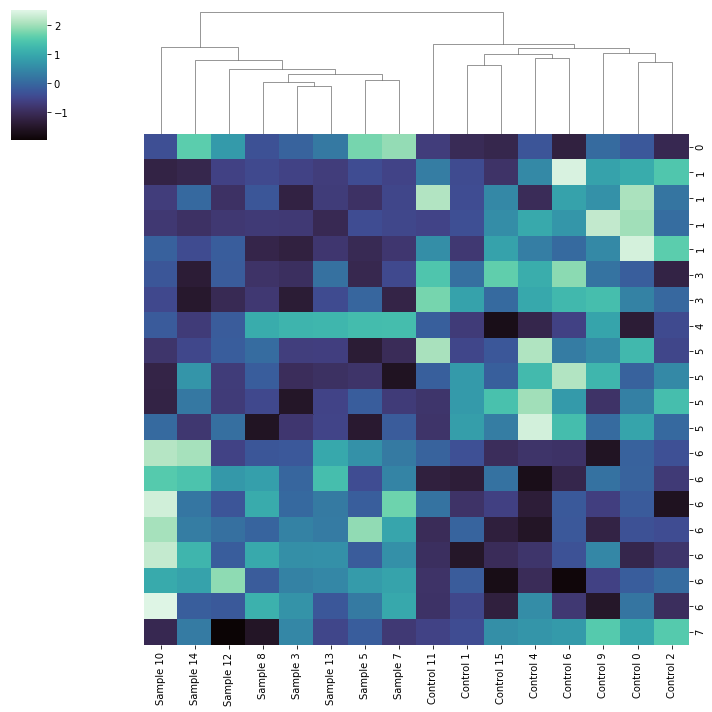

In [19]:
signif_level = 0.01
order = np.argsort(kmeans.labels_[f_stats.pvalue < signif_level])
clustered_values = values_norm[f_stats.pvalue < signif_level][order]
value_df = pd.DataFrame(clustered_values)
value_df.index = kmeans.labels_[f_stats.pvalue < signif_level][order]
value_df.columns = [('Control ' if i in control_columns else 'Sample ') + str(i) for i in range(16)]
seaborn.clustermap(value_df, cmap='mako', row_cluster=False, col_cluster=True)


In [20]:
# PCA
pca = PCA(n_components = 16)
pca.fit(values_norm)
print(pca.explained_variance_ratio_)

[1.18051727e-01 1.05219994e-01 8.19213453e-02 7.52271505e-02
 7.08612215e-02 6.64307877e-02 6.17752883e-02 5.88322093e-02
 5.81017094e-02 5.53891636e-02 5.32560700e-02 5.23602788e-02
 5.00342051e-02 4.81427581e-02 4.43960912e-02 9.26867810e-31]


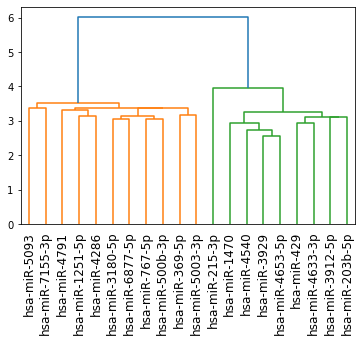

In [21]:
clustering = linkage(values_norm[mirna_signif_id_mask])
fig = plt.figure()

dendrogram(
    clustering,
    labels = list(signifs['Transcript ID(Array Design)']),
    leaf_rotation=90,
)

plt.show()

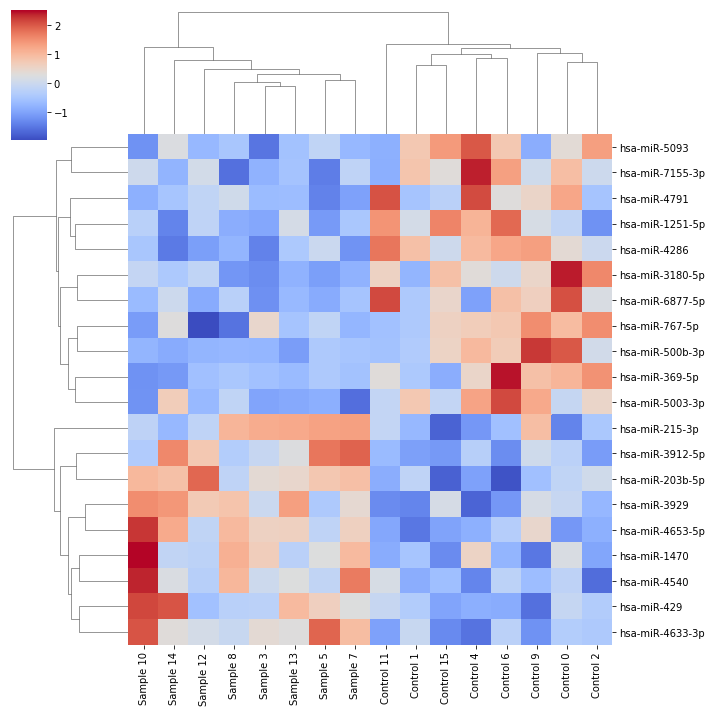

In [22]:
dendro_df = pd.DataFrame(values_norm[mirna_signif_id_mask])
dendro_df.columns = [('Control ' if i in control_columns else 'Sample ') + str(i) for i in range(16)]
dendro_df.index = list(signifs['Transcript ID(Array Design)'])
display(seaborn.clustermap(dendro_df, cmap='coolwarm'))

In [23]:
# COMBAT

gene_names_1 = [raw_data[raw_data['ID'] == id]['Transcript ID(Array Design)'].item() for id in mirna_ids]

gene_names_2 = [raw_data2[raw_data2['ID'] == id]['Human_miRNA'].item() for id in mirna_ids2]

combat_1 = pd.DataFrame(data = values)
combat_1.columns = {'GSM4759790', 'GSM4759791', 'GSM4759792', 'GSM4759793', 
                     'GSM4759794', 'GSM4759795', 'GSM4759796', 'GSM4759797', 'GSM4759798', 'GSM4759799', 
                    'GSM4759800', 'GSM4759801', 'GSM4759802', 'GSM4759803', 'GSM4759804', 'GSM4759805'}
combat_1.insert(0, "miRNA Name", gene_names_1)

combat_2 = pd.DataFrame(data = values2)
combat_2.columns = {'GSM4421278', 'GSM4421279', 'GSM4421280', 'GSM4421281', 'GSM4421282', 
                   'GSM4421283', 'GSM4421284', 'GSM4421285', 'GSM4421286', 'GSM4421287', }
combat_2.insert(0, "miRNA Name", gene_names_2)


df_expression = combat_1.merge(combat_2, on="miRNA Name")

final_genes = df_expression['miRNA Name'].tolist()

df_expression.drop('miRNA Name', axis = 1, inplace = True)
df_expression.index = final_genes

batch = [0] * 16 + [1] * 10

df_corrected = pycombat(df_expression, batch)

print(len(df_corrected))

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
1718


In [24]:
# Significance level
alpha3 = 0.01

# Identifying which samples are controls
control_columns3 = np.array([0, 1, 3, 9, 10, 11, 12, 13, 16, 18, 19, 23, 24])
c3 = np.zeros(26, dtype=bool)
c3[control_columns3] = 1

# Creating accessible matrices from the dataset
mask = np.broadcast_to(c3, (len(df_corrected), 26))

df_corrected_array = df_corrected.to_numpy()

controls3 = df_corrected_array[mask].reshape(-1, 13)
samples3 = df_corrected_array[~mask].reshape(-1, 13)

print(controls3.shape)

# Running one-way ANOVA analysis on the RNAs
f_stats3 = stats.f_oneway(controls3, samples3, axis=-1)

signif_pvalue = []
for i in np.arange(len(f_stats3.pvalue)):
    if f_stats3.pvalue[i] < alpha3:
        signif_pvalue.append(i)

        
print(signif_pvalue)
final_genes = np.array(final_genes)
num_significant3 = np.sum(f_stats3.pvalue < alpha3)
signif_ids3 = final_genes[signif_pvalue]

print(signif_ids3)

(1718, 13)
[792, 1688, 1691]
['hsa-miR-2681-3p' 'hsa-miR-5681a' 'hsa-miR-5684']


Text(0, 0.5, 'Frequency')

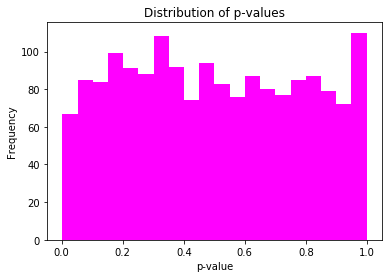

In [25]:
signifs3 = []
mirna_signif_ids3 = []
for sig_id in signif_ids3:
    if not any(final_genes == sig_id):
        continue
    signifs3.append(np.where(final_genes == sig_id)[0][0])

sorted_pvalues3 = np.copy(f_stats3.pvalue)
sorted_pvalues3.sort()

signifs3 = np.array(signifs3)

signif_indices3 = []
for i in np.arange(len(f_stats3.pvalue)):
    if f_stats3.pvalue[i] < alpha3:
        signif_indices3.append(i)

# Plotting distribution of p-values
plt.hist(sorted_pvalues3, bins = 20, color = 'magenta')
plt.title('Distribution of p-values')
plt.xlabel('p-value')
plt.ylabel('Frequency')

In [26]:
regulations3 = np.mean(samples3, axis=-1) > np.mean(controls3, axis=-1)

# True if upregulated, False if downregulated
signif_regulations3 = regulations3[signifs3]

labeled_sig_regs3 = np.stack([
    final_genes[signifs3],
    signif_regulations3
], axis=-1)

print(labeled_sig_regs3)

[['hsa-miR-2681-3p' 'True']
 ['hsa-miR-5681a' 'True']
 ['hsa-miR-5684' 'False']]


In [27]:
# Normalizing data for clustering
values_norm3 = df_corrected_array

values_norm3 = values_norm3 - np.mean(values_norm3, axis=-1, keepdims=True)
values_norm3 = values_norm3 / np.std(values_norm3, axis=-1, keepdims=True)

print(values_norm3.shape)

(1718, 26)


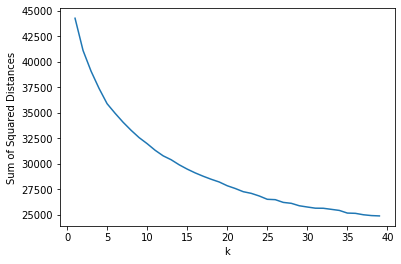

In [28]:
# K-means clustering
sum_of_squared_distances3 = []
for k in range(1, 40):
    kmeans3 = KMeans(n_clusters = k).fit(values_norm3)
    sum_of_squared_distances3.append(kmeans3.inertia_)
    
plt.plot(range(1, 40), sum_of_squared_distances3)
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.show()

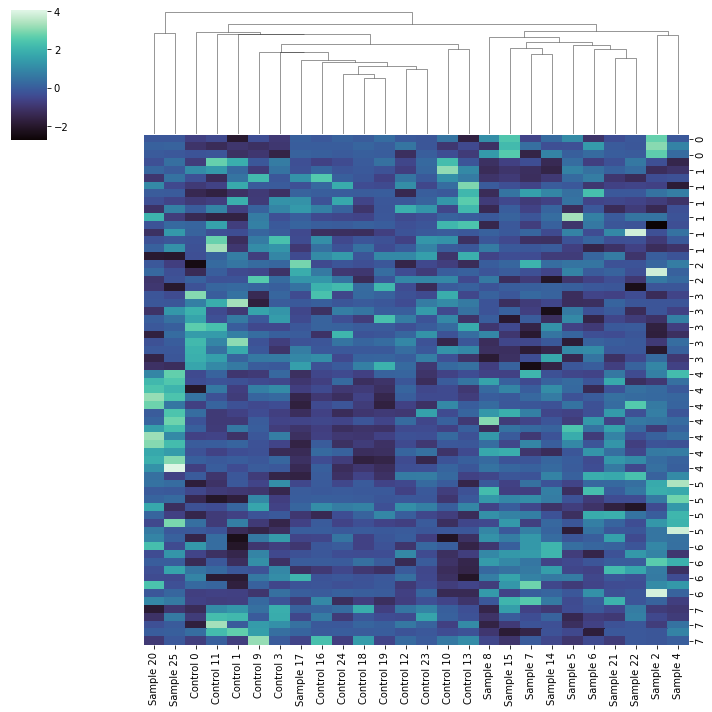

In [29]:
kmeans3 = KMeans(n_clusters = 8).fit(values_norm3)

signif_level3 = 0.05
order3 = np.argsort(kmeans3.labels_[f_stats3.pvalue < signif_level3])
clustered_values3 = values_norm3[f_stats3.pvalue < signif_level3][order3]
value_df3 = pd.DataFrame(clustered_values3)
value_df3.index = kmeans3.labels_[f_stats3.pvalue < signif_level3][order3]
value_df3.columns = [('Control ' if i in control_columns3 else 'Sample ') + str(i) for i in range(26)]
seaborn.clustermap(value_df3, cmap='mako', row_cluster=False, col_cluster=True)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


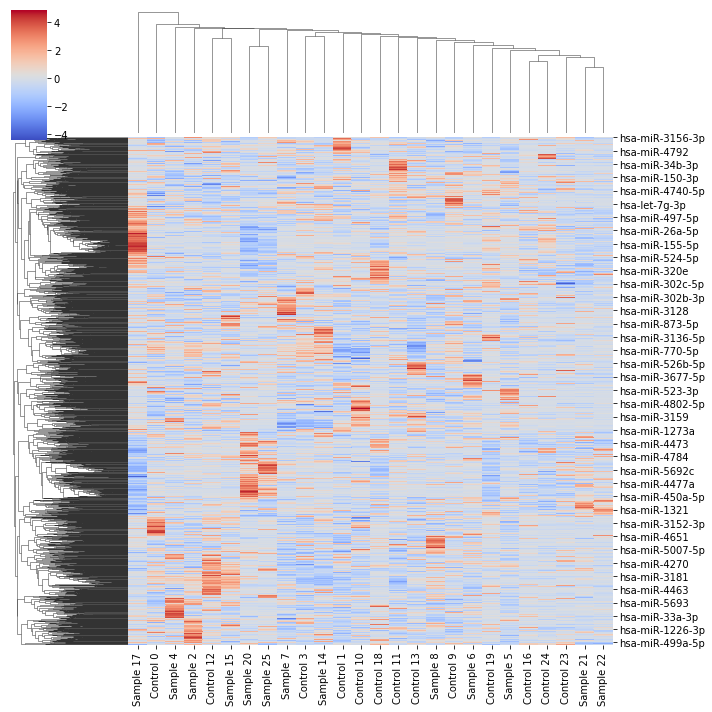

In [30]:
dendro_df3 = pd.DataFrame(values_norm3)
dendro_df3.columns = [('Control ' if i in control_columns3 else 'Sample ') + str(i) for i in range(26)]
dendro_df3.index = list(final_genes)
display(seaborn.clustermap(dendro_df3, cmap='coolwarm'))